# 일반 모델의 변수 중요도
- Permutation Feature Importance


# 라이브러리 불러오기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import *

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session

# 데이터 불러오기

In [4]:
data = pd.read_csv('./data/attrition2.csv')
data.head()

,Attrition,Age,Department,DistanceFromHome,Education,EducationField,Gender,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,0,28,Research & Development,1,3,Medical,Female,Research Scientist,1,Married,3591,1,3,3,3,3,3
1,1,37,Research & Development,2,2,Other,Male,Laboratory Technician,3,Single,2090,6,2,7,3,3,0
2,0,27,Research & Development,8,5,Life Sciences,Male,Laboratory Technician,3,Married,4621,1,4,3,4,3,3
3,0,18,Research & Development,1,3,Life Sciences,Female,Laboratory Technician,4,Single,1611,1,3,0,5,4,0
4,0,29,Research & Development,9,3,Life Sciences,Male,Research Scientist,3,Married,2451,6,1,5,2,2,1


|	변수 명	|	내용	|	구분	|  
|	----	|	----	|	----	|  
|	**Attrition**	|	이직여부, Yes = 1 , No = 0	|	**Target**	|  
|	Age	|	나이	|	숫자	|  
|	BusinessTravel	|	출장 빈도(범주)	|		|  
|	Department	|	현 부서	|		|  
|	DistanceFromHome	|	집-직장 거리(마일)	|	숫자	|  
|	Education	|	교육수준(범주)	|	1 Below College, 2 College, 3 Bachelor, 4 Master, 5 Doctor	|  
|	EducationField	|	전공	|		|  
|	EnvironmentSatisfaction	|	근무환경에 대한 만족도(범주)	|	1 Low, 2 Good, 3 Excellent, 4 Outstanding	|  
|	Gender	|	성별	|		|  
|	JobInvolvement	|	직무 적극성(참여도)	|	1 Low, 2 Medium, 3 High, 4 Very High	|  
|	JobRole	|	직무	|		|  
|	JobSatisfaction	|	직무 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|  
|	MaritalStatus	|	결혼상태	|		|  
|	MonthlyIncome	|	월급	|	숫자	|  
|	NumCompaniesWorked	|	현재까지 근무한 회사 수	|	숫자	|  
|	PercentSalaryHike	|	전년대비 급여인상율(%)	|	숫자	|  
|	RelationshipSatisfaction	|	동료와의 관계 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|  
|	StockOptionLevel	|	스톡옵션 수준 0~3	|	범주	|  
|	TotalWorkingYears	|	총 근무 연수	|	숫자	|  
|	TrainingTimesLastYear	|	전년 교육훈련 횟수	|	숫자	|  
|	WorkLifeBalance	|	워라밸. 일-삶 균형도	|	1 Bad, 2 Good, 3 Better, 4 Best	|  
|	YearsAtCompany	|	현직장 근무 연수	|	숫자	|  
|	YearsInCurrentRole	|	현직무 연수	|	숫자	|  
|	YearsWithCurrManager	|	현 팀장과 근무한 연수	|	숫자	|  


# 필요한 함수 정의하기

In [5]:
# 변수 중요도 plot1
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

# 변수 중요도 plot2
def plot_PFI(pfi, col_names):
    plt.figure(figsize = (14,5))
    plt.subplot(1,2,1)
    for i,vars in enumerate(col_names) :
        sns.kdeplot(pfi.importances[i], label = vars)
    plt.legend()
    plt.grid()

    sorted_idx = pfi.importances_mean.argsort()
    plt.subplot(1,2,2)
    plt.boxplot(pfi.importances[sorted_idx].T, vert=False, labels=col_names[sorted_idx])
    plt.axvline(0, color = 'r')
    plt.grid()
    plt.show()

# 데이터 준비하기

##### x,y 나누기

In [6]:
target = 'Attrition'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [7]:
y.value_counts() / y.shape[0]

0    0.913043
1    0.086957
Name: Attrition, dtype: float64

##### 가변수화

In [8]:
dummy_vars = ['Education','Department','EducationField','Gender','JobRole','JobSatisfaction','MaritalStatus',
              'RelationshipSatisfaction','WorkLifeBalance'] # 가변수화 대상 변수 이름 리스트 만든다
x = pd.get_dummies(x, columns = dummy_vars, drop_first=True)

##### train, validation 분할

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 2023)

In [11]:
print(x_train.shape, x_val.shape)

(920, 38) (230, 38)


##### class balance를 맞추기 위한 resampling

In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
sm_x_train, sm_y_train = smote.fit_resample(x_train, y_train)

##### 스케일링 하기

In [13]:
scaler = MinMaxScaler()
sm_x_train_s = scaler.fit_transform(sm_x_train)
x_val_s = scaler.transform(x_val)

# 모델링

* model1 : SVM
* model2 : KNN

In [14]:
from sklearn.inspection import permutation_importance

## 1. SVM 모델

In [17]:
model1 = SVR()
model1.fit(sm_x_train, sm_y_train)

SVR()

* permutation feature importance 구하기

In [30]:
pfi1 = permutation_importance(model1, x_val_s, y_val, n_repeats=10, scoring = 'r2', random_state=2023)

In [31]:
pfi1

{'importances_mean': array([ 0.01419067,  0.0023517 ,  0.02900431,  0.02263439,  0.01416197,
         0.04714053,  0.01049829,  0.03254604,  0.03604116,  0.04104527,
        -0.0017485 ,  0.131806  ,  0.04326649,  0.26278133,  0.06506626,
         0.18244458,  0.0413563 ,  0.07435242,  0.01059187,  0.09867186,
         0.00051418,  0.02878426,  0.02204654,  0.00403291,  0.08943032,
         0.07968883, -0.01983686,  0.06795624,  0.00401771,  0.09602555,
         0.04791641,  0.04186041,  0.01965212,  0.05199109,  0.07753971,
         0.09785482,  0.21109494,  0.04621175]),
 'importances_std': array([0.0146208 , 0.01010855, 0.01610372, 0.01971992, 0.01631943,
        0.01500655, 0.00715659, 0.02705849, 0.02306983, 0.0112001 ,
        0.00994317, 0.02773152, 0.01608961, 0.03427026, 0.01937298,
        0.02980747, 0.01070987, 0.0139751 , 0.01443224, 0.01037043,
        0.01252812, 0.01583513, 0.02021469, 0.0076774 , 0.01445627,
        0.01987044, 0.0037057 , 0.02317152, 0.04725595, 0.053

* feature별 Score 분포

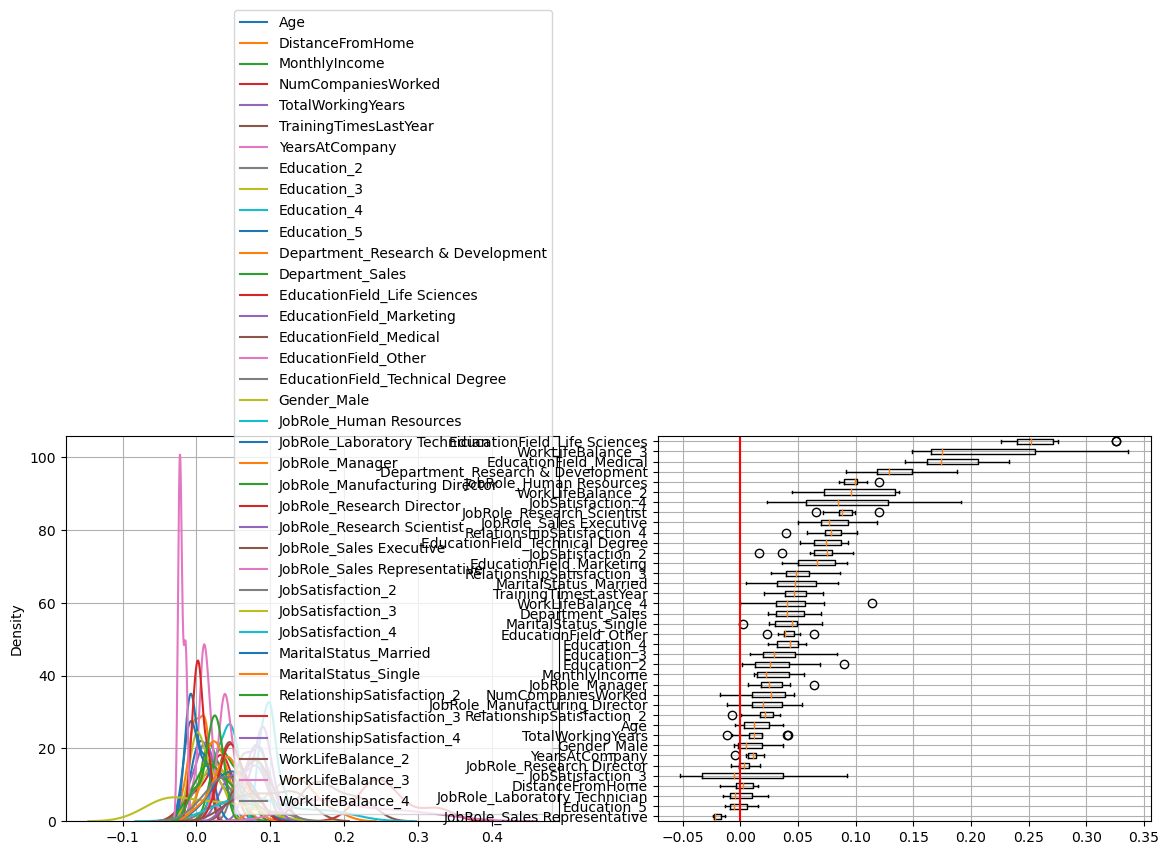

In [32]:
plot_PFI(pfi1, x.columns)

* 평균값으로 변수중요도 그래프 그리기

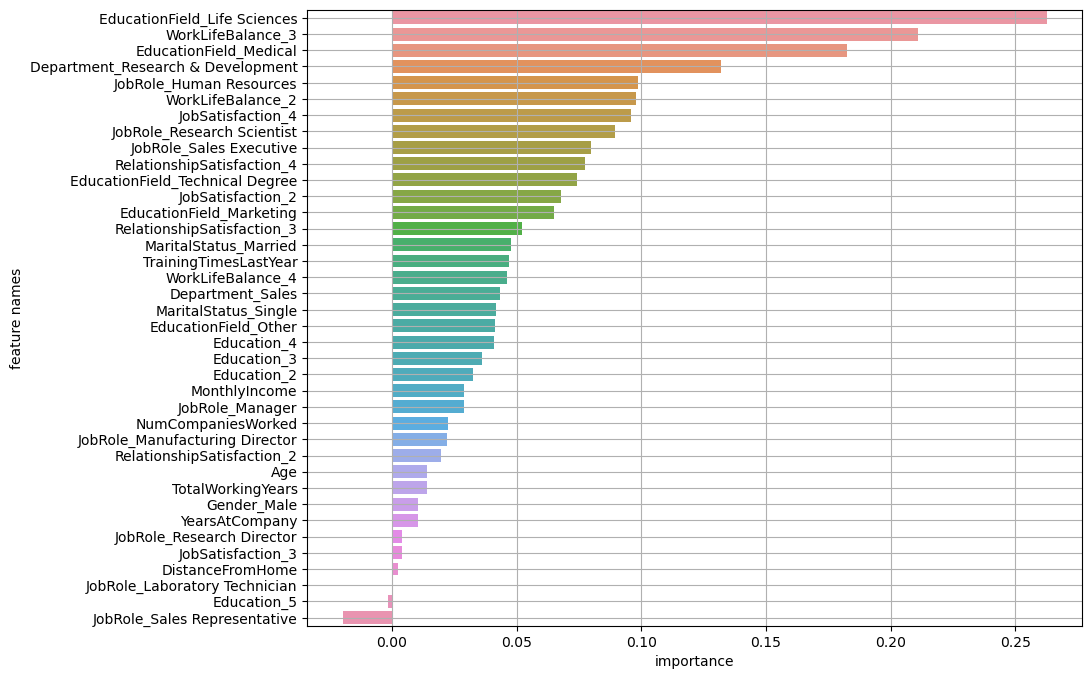

In [33]:
result = plot_feature_importance(pfi1.importances_mean, list(x_train))

## KNN 모델

In [35]:
model2 = KNeighborsRegressor()

model2.fit(sm_x_train_s, sm_y_train)

KNeighborsRegressor()

* permutation feature importance 구하기
    * deep learning 모델에 대해서는 명시적으로 scoring = 'r2'을 지정해 줘야 합니다.

In [36]:
pfi2 = permutation_importance(model2, x_val_s, y_val, n_repeats=10, random_state=2023)

In [37]:
pfi2

{'importances_mean': array([ 0.02868546, -0.01652282,  0.07710651,  0.0828436 ,  0.04429035,
         0.02822649,  0.04520828,  0.0954652 ,  0.20056872,  0.33389873,
         0.02088301,  0.60721377,  0.15145922,  0.34996258,  0.08697431,
         0.26344724,  0.02868546,  0.06356697,  0.04589673,  0.18175106,
         0.04153654,  0.13126465,  0.13126465,  0.04199551,  0.19230731,
         0.09661262, -0.05943627,  0.31967074,  0.13172362,  0.24921926,
         0.32012971, -0.06448491,  0.06379646,  0.34032427,  0.4158244 ,
         0.26505363,  0.37451734,  0.15122973]),
 'importances_std': array([0.03758561, 0.04165998, 0.0276373 , 0.06175158, 0.02888305,
        0.02732783, 0.02475979, 0.0589304 , 0.07406459, 0.05162362,
        0.01328034, 0.10149406, 0.0523102 , 0.12356901, 0.04276593,
        0.11374985, 0.01111279, 0.02264924, 0.06308088, 0.01713615,
        0.03395195, 0.02271309, 0.04275792, 0.00984643, 0.0523585 ,
        0.05017722, 0.01822771, 0.08924554, 0.07329983, 0.108

* feature별 Score 분포

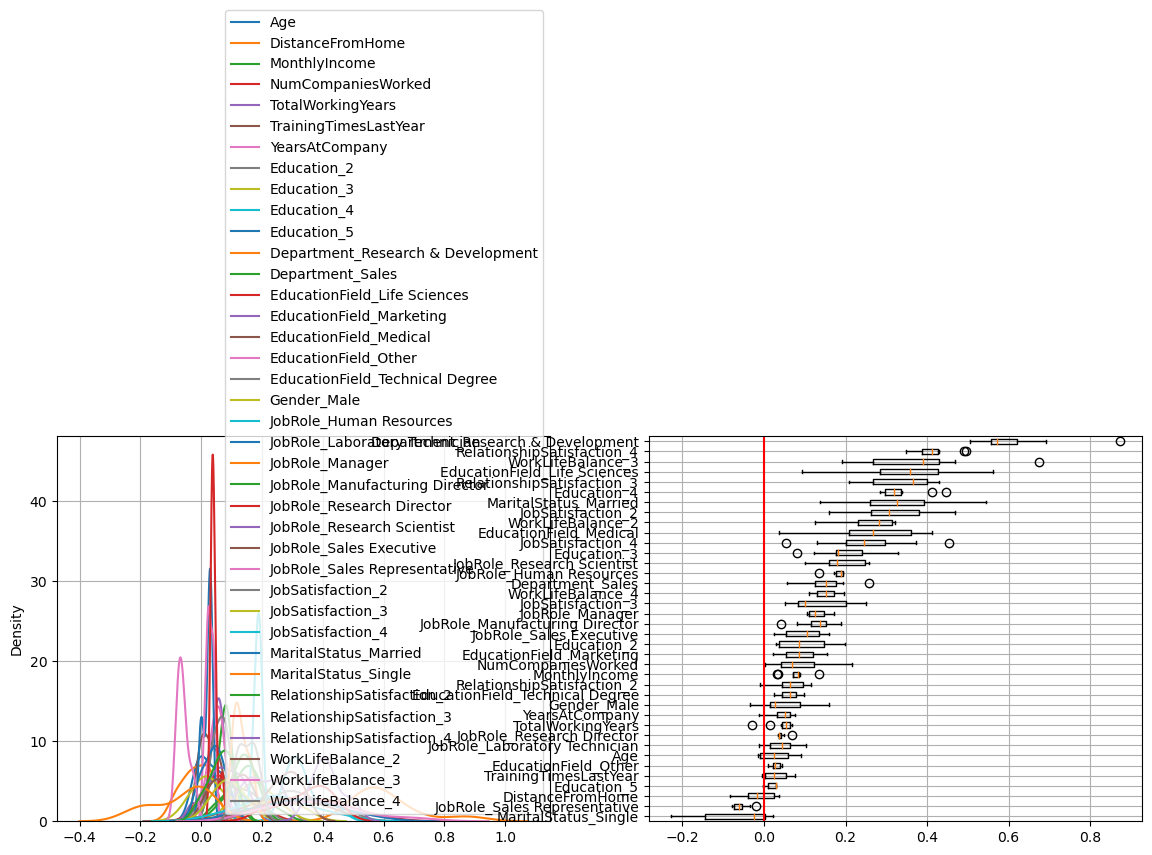

In [38]:
plot_PFI(pfi2, x.columns)

* 평균값으로 변수중요도 그래프 그리기

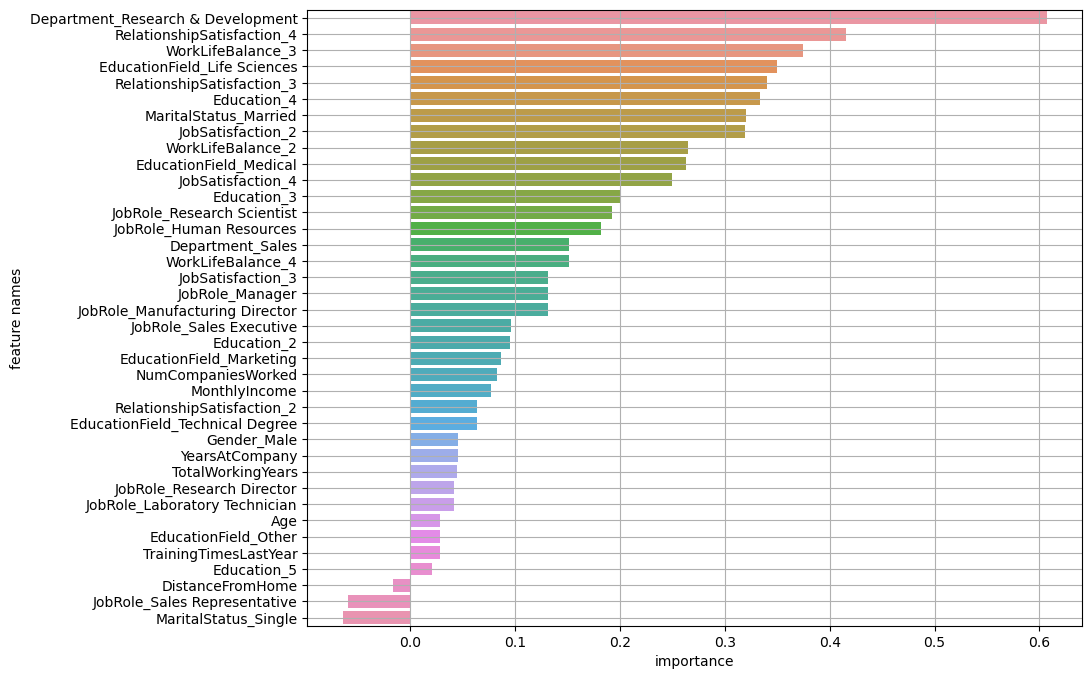

In [39]:
result = plot_feature_importance(pfi2.importances_mean, list(x_train))

In [54]:
from sklearn.metrics import *

In [52]:
pred1 = model1.predict(x_val_s)
print(mean_absolute_error(y_val, pred1))

0.171571520365647


In [53]:
pred2 = model2.predict(x_val_s)
print(mean_absolute_error(y_val, pred2))

0.2182608695652174
